In [1]:
# Data Processing
import pandas as pd
from sklearn import preprocessing         
import re                                 
import string 

In [2]:
# Utility
import numpy as np
from numpy import mean
from collections import Counter
import logging
import time
from imblearn.pipeline import Pipeline
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Word2vec
import gensim

# Natural Language Processing
import nltk 
# nltk.download('stopwords')  # download the stopwords from NLTK 
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from nltk.corpus import wordnet
from wordcloud import WordCloud

In [4]:
# Models
from sklearn import tree
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold 

In [5]:
# Evaluation
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt           
import seaborn as sns

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [7]:
import tensorflow
from tensorflow.keras.layers import Dense

In [8]:
# BERT
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

In [9]:
print(torch.cuda.is_available())

True


In [10]:
# Oversample
from imblearn.over_sampling import SMOTE # for bag of words, tfidf
from sklearn.utils import class_weight # for word embedding

In [11]:
# trainset 
df_train = pd.read_csv('./datasets/SMS_train.csv', encoding ='unicode_escape')
pd.set_option('display.max_colwidth', None)
df_train.head(5)

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,Non-Spam
2,3,"Pity, * was in mood for that. So...any other suggestions?",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",Spam


In [12]:
# testset
df_test = pd.read_csv('./datasets/SMS_test.csv', encoding = 'unicode_escape')
df_test.head(5)

,S. No.,Message_body,Label
0,1,"UpgrdCentre Orange customer, you may now claim your FREE CAMERA PHONE upgrade for your loyalty. Call now on 0207 153 9153. Offer ends 26th July. T&C's apply. Opt-out available",Spam
1,2,"Loan for any purpose £500 - £75,000. Homeowners + Tenants welcome. Have you been previously refused? We can still help. Call Free 0800 1956669 or text back 'help'",Spam
2,3,Congrats! Nokia 3650 video camera phone is your Call 09066382422 Calls cost 150ppm Ave call 3mins vary from mobiles 16+ Close 300603 post BCM4284 Ldn WC1N3XX,Spam
3,4,URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09058094455 from land line. Claim 3030. Valid 12hrs only,Spam
4,5,Someone has contacted our dating service and entered your phone because they fancy you! To find out who it is call from a landline 09111032124 . PoBox12n146tf150p,Spam


In [13]:
print("Shape of train set:", df_train.shape)
print("Shape of train set:", df_test.shape)

Shape of train set: (957, 3)
Shape of train set: (125, 3)


In [14]:
print("Number of NaN values in train set:", df_train.isnull().sum().sum())
print("Number of NaN values in train set:", df_test.isnull().sum().sum())

Number of NaN values in train set: 0
Number of NaN values in train set: 0


# Data Preprocessing

In [15]:
def data_preprocessing(data):
    data = data.drop(['S. No.'], axis=1)  # dropping unnecesary column
    label_encoder = preprocessing.LabelEncoder()  # label encoding for 'Label' column
    data['Label'] = label_encoder.fit_transform(data['Label'])   # label encoding column
    return data

In [16]:
df_train = data_preprocessing(df_train)
df_test = data_preprocessing(df_test)

In [17]:
print('Column Name\tNull presence?\n')
print(df_train.isnull().any())  # checking for null values if any
print(df_test.isnull().any())

Column Name	Null presence?

Message_body    False
Label           False
dtype: bool
Message_body    False
Label           False
dtype: bool


In [18]:
def process_mail(mail):
    """Process mail function.
    Input:
        mail: a string containing meassage body
    Output:
        mail_clean: a string containing the processed body

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # tokenize reviews
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    mail_tokens = tokenizer.tokenize(mail)

    mail_clean = []
    for word in mail_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # mail_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            mail_clean.append(stem_word)
            
    mail_clean = " ".join(mail_clean) # Join words in a list together as string
    
    return mail_clean

In [19]:
# using the process_mail function for:
# 1. Removing stop words
# 2. Tokenization
# 3. Stemming
df_train['Message_body'] = df_train['Message_body'].apply(lambda x: process_mail(x))
df_test['Message_body'] = df_test['Message_body'].apply(lambda x: process_mail(x))

In [20]:
# Train Test in general
x_train = df_train['Message_body']
x_test = df_test['Message_body']

y_train = df_train['Label']
y_test = df_test['Label']

In [21]:
# trainset is imbalanced
print(Counter(y_train))

Counter({0: 835, 1: 122})


In [22]:
pd.set_option('display.max_colwidth', None)
df_train.head(5)

,Message_body,Label
0,rofl true name,0
1,guy bitch act like i'd interest buy someth els next week gave us free,0
2,piti mood ... suggest,0
3,ü b go esplanad fr home,0
4,2nd time tri 2 contact u u £ 750 pound prize 2 claim easi call 08718727200 8 1 10p per minut bt-national-r,1


# Word Cloud

In [44]:
nonspam_train = df_train[df_train['Label'] == 0] 
spam_train = df_train[df_train['Label'] == 1]

nonspam_test = df_test[df_test['Label'] == 0] 
spam_test = df_test[df_test['Label'] == 1]

2021-11-04 15:31:03,360 : INFO : NumExpr defaulting to 8 threads.


In [45]:
spam = spam_train['Message_body'].values 
nonspam = nonspam_train['Message_body'].values 

(-0.5, 999.5, 499.5, -0.5)

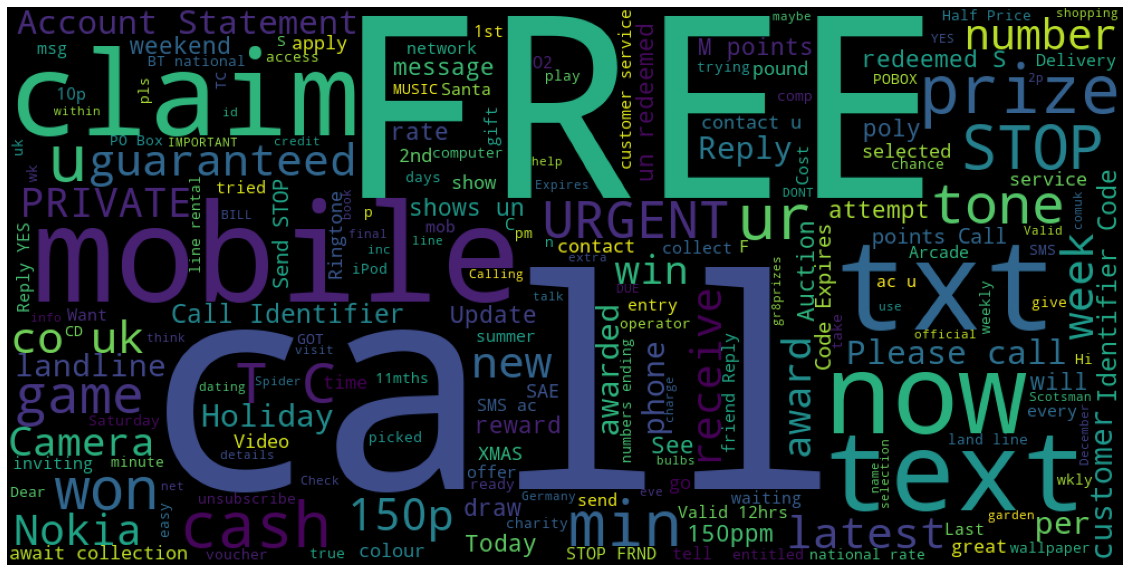

In [46]:
spam_text =(" ").join(spam)
wordcloud = WordCloud(width = 1000, height = 500).generate(spam_text)
fig = plt.figure(figsize=(20,18))
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

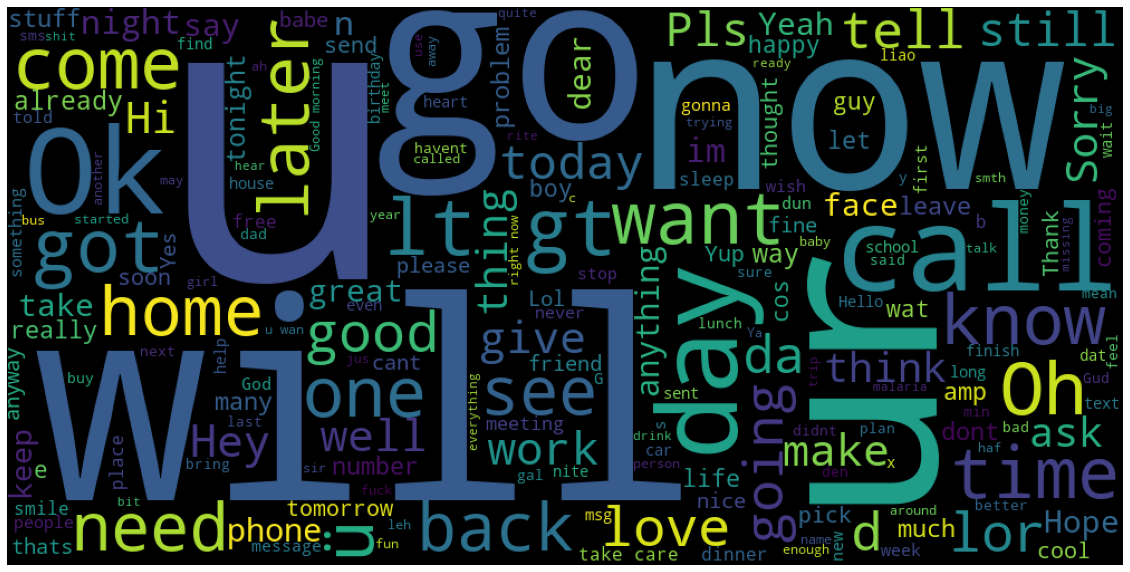

In [47]:
nonspam_text =(" ").join(nonspam)
wordcloud = WordCloud(width = 1000, height = 500).generate(nonspam_text)
fig = plt.figure(figsize=(20,18))
plt.imshow(wordcloud)
plt.axis('off')

# Ngram

In [48]:
df_combined = pd.concat([df_train, df_test])

In [49]:
df_combined = df_combined.reset_index().drop('index', axis=1)

In [50]:
df_combined_ham = df_combined[df_combined['Label'] == 0]
df_combined_spam = df_combined[df_combined['Label'] == 1]

In [51]:
def Get_ngram(sentence, ngram_counts):
    word_list = sentence.split()
    words_tuple = nltk.ngrams(word_list, ngram_counts)
    temp = []
    for _ in words_tuple:
        temp.append(_)
    return temp

In [52]:
def plot_ngram(num = 7, ngram_counts = 3):
    temp_spam = df_combined_spam['Message_body'].apply(Get_ngram, ngram_counts = ngram_counts)
    temp_ham = df_combined_ham['Message_body'].apply(Get_ngram, ngram_counts = ngram_counts)
    
    bigram_spam = pd.Series(dtype = 'object')
    for i in temp_spam:
        bigram_spam = pd.concat([bigram_spam,pd.Series(i, dtype = 'object')])
    bigram_spam.reset_index(drop=True)

    bigram_ham = pd.Series(dtype = 'object')
    for i in temp_ham:
        bigram_ham = pd.concat([bigram_ham,pd.Series(i, dtype = 'object')])
    bigram_ham.reset_index(drop = True)
    
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    words_spam = []
    words_ham = []
    values_spam = []
    values_ham = []
    for i, j in zip(bigram_spam.value_counts().index[:num], bigram_ham.value_counts().index[:num]):
        words_spam.append(i)
        words_ham.append(j)
    for i, j in zip(bigram_spam.value_counts().values[:num], bigram_ham.value_counts().values[:num]):
        values_spam.append(i)
        values_ham.append(j)
    ax[0].barh(np.arange(len(words_spam)), values_spam, color = "#CFAAB7")
    ax[0].set_yticks(np.arange(len(words_spam)))
    ax[0].set_yticklabels(words_spam, fontsize = 14)
    
    ax[1].barh(np.arange(len(words_ham)), values_ham, color = '#AAC2CF')
    ax[1].set_yticks(np.arange(len(words_ham)))
    ax[1].set_yticklabels(words_ham, fontsize = 14)
    
    ax[0].set_title('SPAM')
    ax[1].set_title('HAM')
    
    fig.tight_layout()

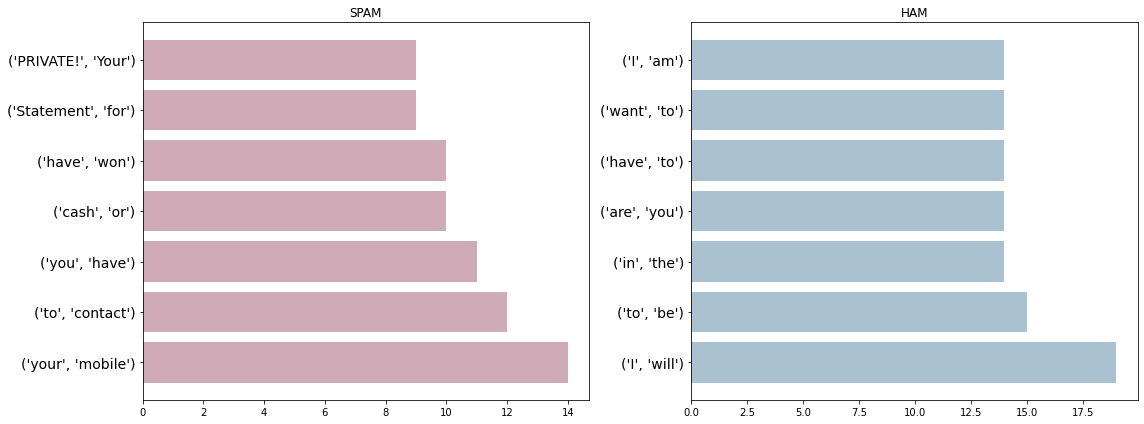

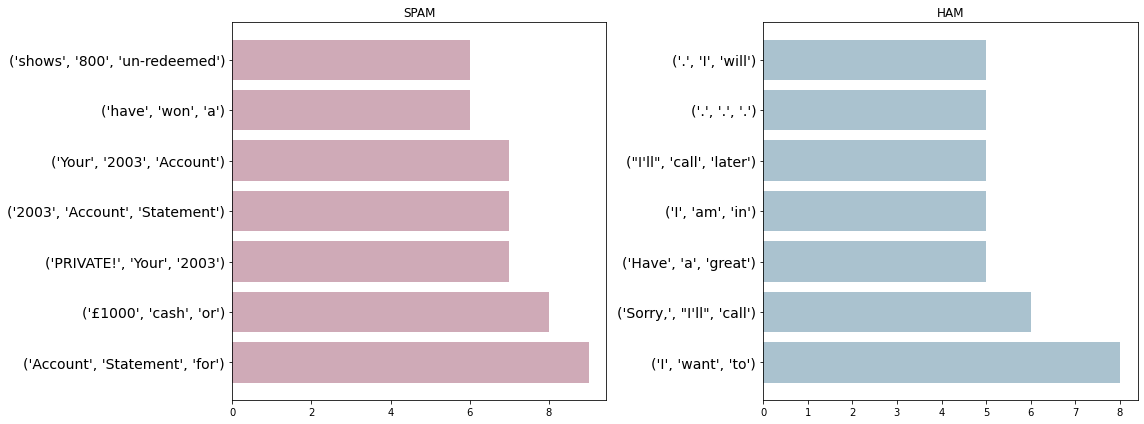

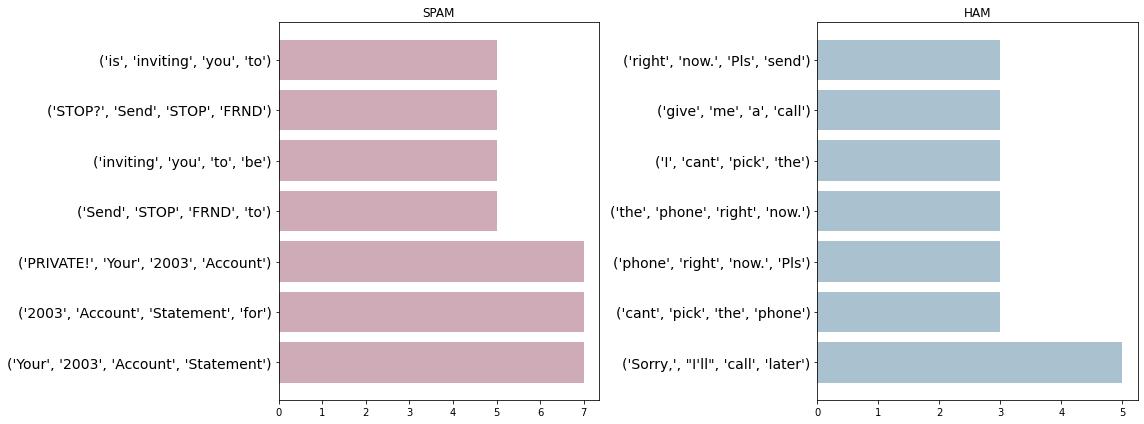

In [53]:
plot_ngram(num = 7, ngram_counts = 2)
plot_ngram(num = 7, ngram_counts = 3)
plot_ngram(num = 7, ngram_counts = 4)

# Bag of Words - CountVector

In [54]:
cv = CountVectorizer(analyzer = 'word', lowercase = False) 

In [55]:
# Train set
x_train_cv = cv.fit_transform(x_train)  # predictor variable 'x'
y_train_cv = pd.DataFrame(y_train)  # response variable 'y'

# Test set
x_test_cv = cv.transform(x_test)  # predictor variable 'x'
y_test_cv = pd.DataFrame(y_test)  # response variable 'y'

In [56]:
# find the optimum number of k_neighbours to use for SMOTE
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
    # define pipeline
    a = LogisticRegression(random_state = 42)
    over = SMOTE(random_state= 42, k_neighbors = k)
    steps = [('over', over), ('model', a)]
    pipeline = Pipeline(steps = steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 42)
    scores = cross_val_score(pipeline, x_train_cv, y_train_cv, scoring='accuracy', cv = cv, n_jobs = -1)
    score = mean(scores)
    print('> k = %d, Mean Accuracy: %.3f' % (k, score))
    
# k_neighbors = 6 will be used as the train set accuracy is the highest

> k = 1, Mean Accuracy: 0.840
> k = 2, Mean Accuracy: 0.850
> k = 3, Mean Accuracy: 0.842
> k = 4, Mean Accuracy: 0.837
> k = 5, Mean Accuracy: 0.842
> k = 6, Mean Accuracy: 0.862
> k = 7, Mean Accuracy: 0.841
> k = 8, Mean Accuracy: 0.837
> k = 9, Mean Accuracy: 0.844
> k = 10, Mean Accuracy: 0.841


In [57]:
# oversample the trainset
oversample = SMOTE(random_state = 42, k_neighbors = 6)
x_train_cv, y_train_cv = oversample.fit_resample(x_train_cv, y_train_cv)

In [58]:
# balanced
print((y_train_cv == 0).sum(axis = 0))
print((y_train_cv == 1).sum(axis = 0))

0    835
dtype: int64
0    835
dtype: int64


### Logistic Regression

Assumptions of logistic regression:

* There is little to no multicollinearity between the independent variables.
* The independent variables are linearly related to the log odds (log (p/(1-p)).
* The dependent variable is binary
* There are no non-meaningful variables as they might lead to errors.
* There are no outliers.

https://learn.g2.com/logistic-regression

In [59]:
m1 = LogisticRegression(random_state = 42)
m1.fit(x_train_cv, y_train_cv.values.ravel())

m1train = m1.predict(x_train_cv)
cm1train = confusion_matrix(y_train_cv, m1train)
m1trainAccuracy = (cm1train[0,0] + cm1train[1,1])/sum(sum(cm1train))

m1test = m1.predict(x_test_cv)
cm1test = confusion_matrix(y_test_cv, m1test)
m1testAccuracy = (cm1test[0,0] + cm1test[1,1])/sum(sum(cm1test))

print("Logistic Regression")
print("===================")
print("Confusion Matrix (Train) \n", cm1train)
print("\nAccuracy (Train)", m1trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n", cm1test)
print("\nAccuracy (Test)", m1testAccuracy)

Logistic Regression
Confusion Matrix (Train) 
 [[809  26]
 [  4 831]]

Accuracy (Train) 0.9820359281437125
Confusion Matrix (Test) 
 [[44  5]
 [14 62]]

Accuracy (Test) 0.848


### Decision Tree 

The decision tree serves as a guideline for us in choosing the max_depth range when using randomised search. 
From the tree, we can see the max depth of the unpruned tree, and also the depth of the pruned tree (using cost-complexity pruning).

In [60]:
# decision Tree Unpruned
cart = tree.DecisionTreeClassifier(random_state = 42)
cart.fit(x_train_cv, y_train_cv)

carttrain = cart.predict(x_train_cv)
carttrain = confusion_matrix(carttrain, y_train_cv)
carttrainAccuracy = (carttrain[0,0] + carttrain[1,1]) / sum(sum(carttrain))

carttest = cart.predict(x_test_cv)
carttest = confusion_matrix(carttest, y_test_cv)
carttestAccuracy = (carttest[0,0] + carttest[1,1]) / sum(sum(carttest))

# fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,7.5), dpi = 80)
# tree.plot_tree(cart, filled = True, fontsize = 7);
# fig.savefig('CART Tree.png')

print("Decision Tree Unpruned")
print("===================")
print("The depth of the unpruned tree is", cart.get_depth())
print("===================")
print("Confusion Matrix (Train) \n", carttrain)
print("\nAccuracy (Train)", carttrainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n", carttest)
print("\nAccuracy (Test)", carttestAccuracy)

Decision Tree Unpruned
The depth of the unpruned tree is 204
Confusion Matrix (Train) 
 [[832   0]
 [  3 835]]

Accuracy (Train) 0.9982035928143712
Confusion Matrix (Test) 
 [[41 18]
 [ 8 58]]

Accuracy (Test) 0.792


Optimal ccp_alpha is 0.0005837653433354155


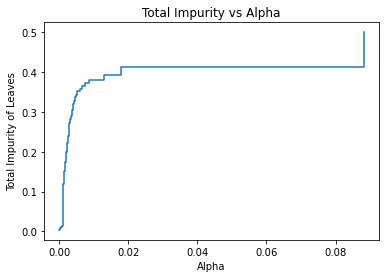

In [61]:
# post pruning using ccp_alphas
path = cart.cost_complexity_pruning_path(x_train_cv, y_train_cv.values.ravel()) # cost of increasing the complexity of the model
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas, impurities)

fig, ax = plt.subplots()
ax.plot(ccp_alphas[1:], impurities[1:], drawstyle = "steps-post")
ax.set_xlabel("Alpha")
ax.set_ylabel("Total Impurity of Leaves")
ax.set_title("Total Impurity vs Alpha")

# do not loop through the first value of ccp_alpha since it is zero (i.e. no cost incurred for pruning)
grid = dict() 
grid['ccp_alpha'] = [alpha for alpha in ccp_alphas[1:]]

# define evaluation process
grid_search1 = GridSearchCV(estimator = cart, param_grid = grid, n_jobs = 1, cv = 10, scoring = 'accuracy')
grid_search1.fit(x_train_cv, y_train_cv.values.ravel())  
grid_result1 = grid_search1.best_params_['ccp_alpha']
print("Optimal ccp_alpha is", grid_result1)

In [62]:
postpruning = tree.DecisionTreeClassifier(random_state = 42, ccp_alpha = grid_result1)
postpruning.fit(x_train_cv, y_train_cv)

# plotting the tree after post pruning
# fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,7.5), dpi = 80)
# tree.plot_tree(postpruning, filled = True, fontsize = 7)
# fig.savefig('CART Tree Post Pruning.png')

print("The depth of the pruned tree is", postpruning.get_depth())

The depth of the pruned tree is 170


However, since the tree is too large, we will not use 'max_depth' as one of the hyperparameters for tuning.

### Random Forest 
RandomizedSearchCV is used as it is able to search over the same domain for models that are as good or better within a small fraction of the computation time. Granting random search the same computational budget, random search finds better models by effectively searching a larger, less promising configuration space (Bergstra, Bengio, 2012). 

https://www.jmlr.org/papers/v13/bergstra12a.html

3 parameters will be used to tune the model:
* n_estimators
* min_sample_split
* min_sample_leaf

In [63]:
m2 = RandomForestClassifier(random_state = 42)
grid = dict() 
grid['n_estimators'] = [150, 200, 250, 300]
grid['min_samples_split'] = [5, 10, 15]
grid['min_samples_leaf'] = [2, 4, 8]
grid['bootstrap'] = [True]

# define evaluation process
grid_search2 = RandomizedSearchCV(estimator = m2, param_distributions = grid, n_jobs = -1, cv = 10, scoring = 'accuracy', random_state = 42)
grid_search2.fit(x_train_cv, y_train_cv.values.ravel())  
grid_result2 = grid_search2.best_params_

# summarise the best score and configuration
print("Best: %f using %s" % (grid_search2.best_score_, grid_search2.best_params_))

Best: 0.896407 using {'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 2, 'bootstrap': True}


In [64]:
# evaluation
m2train = grid_search2.predict(x_train_cv)
cm2train = confusion_matrix(y_train_cv, m2train)
m2trainAccuracy = (cm2train[0,0] + cm2train[1,1])/ sum(sum(cm2train))

m2test = grid_search2.predict(x_test_cv)
cm2test = confusion_matrix(y_test_cv, m2test)
m2testAccuracy = (cm2test[0,0] + cm2test[1,1])/ sum(sum(cm2test))

print("Random Forest Optimised")
print("===================")
print("Confusion Matrix (Train) \n", cm2train)
print("\nAccuracy (Train)", m2trainAccuracy)

print("===================")
print("Confusion Matrix (Test) \n", cm2test)
print("\nAccuracy (Test)", m2testAccuracy)
print("===================")
print(classification_report(y_test, m2test))

Random Forest Optimised
Confusion Matrix (Train) 
 [[722 113]
 [ 13 822]]

Accuracy (Train) 0.9245508982035928
Confusion Matrix (Test) 
 [[42  7]
 [ 8 68]]

Accuracy (Test) 0.88
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        49
           1       0.91      0.89      0.90        76

    accuracy                           0.88       125
   macro avg       0.87      0.88      0.87       125
weighted avg       0.88      0.88      0.88       125



### XGBoost

4 parameters will be used to tune the model:
* n_estimators
* learning_rate
* subsample
* min_samples_split

In [65]:
m3 = GradientBoostingClassifier(random_state = 42)
grid = dict() 
grid['n_estimators'] = [200, 300, 400, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['min_samples_split'] = [3, 5, 10]

# define evaluation process
grid_search3 = RandomizedSearchCV(estimator = m3, param_distributions = grid, n_jobs = 1, cv = 10, scoring = 'accuracy', random_state = 42)
grid_search3.fit(x_train_cv, y_train_cv.values.ravel())
grid_result3 = grid_search3.best_params_

# summarise the best score and configuration
print("Best: %f using %s" % (grid_search3.best_score_, grid_search3.best_params_))

Best: 0.904790 using {'subsample': 0.5, 'n_estimators': 200, 'min_samples_split': 10, 'learning_rate': 0.1}


In [66]:
# evaluation
m3train = grid_search3.predict(x_train_cv)
cm3train = confusion_matrix(y_train_cv, m3train)
m3trainAccuracy = (cm3train[0,0] + cm3train[1,1])/ sum(sum(cm3train))

m3test = grid_search3.predict(x_test_cv)
cm3test = confusion_matrix(y_test_cv, m3test)
m3testAccuracy = (cm3test[0,0] + cm3test[1,1])/ sum(sum(cm3test))

print("XGBoost Optimised")
print("===================")
print("Confusion Matrix (Train) \n", cm3train)
print("\nAccuracy (Train)", m3trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n", cm3test)
print("\nAccuracy (Test)", m3testAccuracy)
print("===================")
print(classification_report(y_test, m3test))

XGBoost Optimised
Confusion Matrix (Train) 
 [[764  71]
 [ 10 825]]

Accuracy (Train) 0.951497005988024
Confusion Matrix (Test) 
 [[45  4]
 [12 64]]

Accuracy (Test) 0.872
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        49
           1       0.94      0.84      0.89        76

    accuracy                           0.87       125
   macro avg       0.87      0.88      0.87       125
weighted avg       0.88      0.87      0.87       125



### Multi Layer Perceptron

MLP was chosen instead of RNN since Bag-of-Words does not have any sequential data (Brownlee, 2018). MLP are effective for classification prediction problems where inputs are assigned a class or label.

https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/

In [67]:
m4 = Sequential()
m4.add(Dense(12, input_dim = x_train_cv.shape[1] , activation = 'relu', name = 'layer1'))
m4.add(Dropout(0.2))
m4.add(Dense(8, activation = 'relu', name = 'layer2'))
m4.add(Dropout(0.2))
m4.add(Dense(1, activation = 'sigmoid', name = 'output'))
m4.summary()

m4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
m4.fit(x_train_cv, y_train_cv.values.ravel(), batch_size = 512, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 12)                32352     
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
layer2 (Dense)               (None, 8)                 104       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


D:\Users\Anaconda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/layer1/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/layer1/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/layer1/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


4/4 [==============================] - 3s 19ms/step - loss: 0.6881 - accuracy: 0.4725
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6781 - accuracy: 0.6036
Epoch 3/50
4/4 [==============================] - 0s 6ms/step - loss: 0.6673 - accuracy: 0.6605
Epoch 4/50
4/4 [==============================] - 0s 3ms/step - loss: 0.6566 - accuracy: 0.7096
Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 0.6458 - accuracy: 0.7234
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.6319 - accuracy: 0.7509
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.6176 - accuracy: 0.7539
Epoch 8/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6040 - accuracy: 0.7713
Epoch 9/50
4/4 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.7760
Epoch 10/50
4/4 [==============================] - 0s 3ms/step - loss: 0.5690 - accuracy: 0.7976
Epoch 11/50
4/4 [==============================]

In [68]:
# evaluation
m4train = m4.predict(x_train_cv)
m4train = np.where(m4train > 0.5, 1, 0)
cm4train = confusion_matrix(y_train_cv, m4train)
m4trainAccuracy = (cm4train[0,0] + cm4train[1,1])/sum(sum(cm4train))

m4test = m4.predict(x_test_cv)
m4test = np.where(m4test > 0.5, 1, 0)
cm4test = confusion_matrix(y_test_cv, m4test)
m4testAccuracy = (cm4test[0,0] + cm4test[1,1])/sum(sum(cm4test))

print("MLP")
print("===================")
print("Confusion Matrix (Train) \n", cm4train)
print("\nAccuracy (Train)", m4trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n",cm4test)
print("\nAccuracy (Test)", m4testAccuracy)

MLP
Confusion Matrix (Train) 
 [[821  14]
 [  0 835]]

Accuracy (Train) 0.9916167664670659
Confusion Matrix (Test) 
 [[45  4]
 [13 63]]

Accuracy (Test) 0.864


# Bag of Words - Tf-idf

In [69]:
vectorizer = TfidfVectorizer()

In [70]:
# Train set
x_train_tfid = vectorizer.fit_transform(x_train)  # predictor variable 'X'
y_train_tfid = pd.DataFrame(y_train)  # response variable 'y'

# Test set
x_test_tfid = vectorizer.transform(x_test)  # predictor variable 'X'
y_test_tfid = pd.DataFrame(y_test)  # response variable 'y'

In [71]:
# find the optimum number of k_neighbours to use for SMOTE
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
    # define pipeline
    a = LogisticRegression(random_state = 42)
    over = SMOTE(random_state = 42, k_neighbors = k)
    steps = [('over', over), ('model', a)]
    pipeline = Pipeline(steps = steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 42)
    scores = cross_val_score(pipeline, x_train_tfid, y_train_tfid, scoring ='accuracy', cv = cv, n_jobs = -1)
    score = mean(scores)
    print('> k = %d, Mean Accuracy: %.3f' % (k, score))
    
# k_neighbors = 6 will be used to ensure standardization

> k = 1, Mean Accuracy: 0.944
> k = 2, Mean Accuracy: 0.946
> k = 3, Mean Accuracy: 0.947
> k = 4, Mean Accuracy: 0.945
> k = 5, Mean Accuracy: 0.946
> k = 6, Mean Accuracy: 0.946
> k = 7, Mean Accuracy: 0.946
> k = 8, Mean Accuracy: 0.947
> k = 9, Mean Accuracy: 0.946
> k = 10, Mean Accuracy: 0.947


In [72]:
# oversample the trainset
oversample = SMOTE(k_neighbors = 6)
x_train_tfid, y_train_tfid = oversample.fit_resample(x_train_tfid, y_train_tfid)

In [73]:
# balanced
print((y_train_tfid == 0).sum(axis = 0))
print((y_train_tfid == 1).sum(axis = 0))

0    835
dtype: int64
0    835
dtype: int64


### Logistic Regression

In [74]:
m5 = LogisticRegression(random_state = 42)
m5.fit(x_train_tfid, y_train_tfid.values.ravel())

m5train = m5.predict(x_train_tfid)
cm5train = confusion_matrix(y_train_tfid, m5train)
m5trainAccuracy = (cm5train[0,0] + cm5train[1,1])/sum(sum(cm5train))

m5test = m5.predict(x_test_tfid)
cm5test = confusion_matrix(y_test_tfid, m5test)
m5testAccuracy = (cm5test[0,0] + cm5test[1,1])/sum(sum(cm5test))

print("Logistic Regression")
print("===================")
print("Confusion Matrix (Train) \n", cm5train)
print("\nAccuracy (Train)", m5trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n", cm5test)
print("\nAccuracy (Test)", m5testAccuracy)

Logistic Regression
Confusion Matrix (Train) 
 [[828   7]
 [  3 832]]

Accuracy (Train) 0.9940119760479041
Confusion Matrix (Test) 
 [[49  0]
 [12 64]]

Accuracy (Test) 0.904


### Decision Tree

Similarly, decision tree will be used as a guideline for us in choosing the suitable depth range in RandomizedSearchCV later.

In [75]:
# decision Tree Unpruned
cart = tree.DecisionTreeClassifier(random_state = 42)
cart.fit(x_train_tfid, y_train_tfid)

carttrain = cart.predict(x_train_tfid)
carttrain = confusion_matrix(carttrain, y_train_tfid)
carttrainAccuracy = (carttrain[0,0] + carttrain[1,1]) / sum(sum(carttrain))

carttest = cart.predict(x_test_tfid)
carttest = confusion_matrix(carttest, y_test_tfid)
carttestAccuracy = (carttest[0,0] + carttest[1,1]) / sum(sum(carttest))

# fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,7.5), dpi = 80)
# tree.plot_tree(cart, filled = True, fontsize = 7);
# fig.savefig('CART Tree.png')

print("Decision Tree Unpruned")
print("===================")
print("The depth of the unpruned tree is", cart.get_depth())
print("===================")
print("Confusion Matrix (Train) \n", carttrain)
print("\nAccuracy (Train)", carttrainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n", carttest)
print("\nAccuracy (Test)", carttestAccuracy)


Decision Tree Unpruned
The depth of the unpruned tree is 16
Confusion Matrix (Train) 
 [[835   0]
 [  0 835]]

Accuracy (Train) 1.0
Confusion Matrix (Test) 
 [[48 14]
 [ 1 62]]

Accuracy (Test) 0.88


Optimal ccp_alpha is 0.0010778443113772457


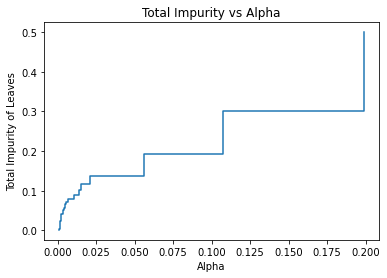

In [76]:
# post pruning using ccp_alphas
path = cart.cost_complexity_pruning_path(x_train_tfid, y_train_tfid.values.ravel()) # cost of increasing the complexity of the model
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas, impurities)

# plotting the tree after post-pruning
fig, ax = plt.subplots()
ax.plot(ccp_alphas[1:], impurities[1:], drawstyle = "steps-post")
ax.set_xlabel("Alpha")
ax.set_ylabel("Total Impurity of Leaves")
ax.set_title("Total Impurity vs Alpha")

# do not loop through the first value of ccp_alpha since it is zero (i.e. no cost incurred for pruning)
grid = dict() 
grid['ccp_alpha'] = [alpha for alpha in ccp_alphas[1:]]

# define evaluation process
grid_search1 = GridSearchCV(estimator = cart, param_grid = grid, n_jobs = -1, cv = 10, scoring = 'accuracy')
grid_search1.fit(x_train_tfid, y_train_tfid.values.ravel())  
grid_result1 = grid_search1.best_params_['ccp_alpha']
print("Optimal ccp_alpha is", grid_result1)

In [77]:
# evaluation
cartatrain = grid_search1.predict(x_train_tfid)
cartatrain = confusion_matrix(cartatrain, y_train_tfid)
cartatrainAccuracy = (cartatrain[0,0] + cartatrain[1,1]) / sum(sum(cartatrain))

cartatest = grid_search1.predict(x_test_tfid)
cartatest = confusion_matrix(cartatest, y_test_tfid)
cartatestAccuracy = (cartatest[0,0] + cartatest[1,1]) / sum(sum(cartatest))

print("Post Pruning Decision Tree Using CCP")
print("===================")
print("Confusion Matrix (Train) \n", cartatrain)
print("\nAccuracy (Train)", cartatrainAccuracy)

print("===================")
print("Confusion Matrix (Test) \n", cartatest)
print("\nAccuracy (Test)", cartatestAccuracy)
print("===================")

Post Pruning Decision Tree Using CCP
Confusion Matrix (Train) 
 [[834   0]
 [  1 835]]

Accuracy (Train) 0.9994011976047904
Confusion Matrix (Test) 
 [[48 14]
 [ 1 62]]

Accuracy (Test) 0.88


The depth of the pruned tree is 16


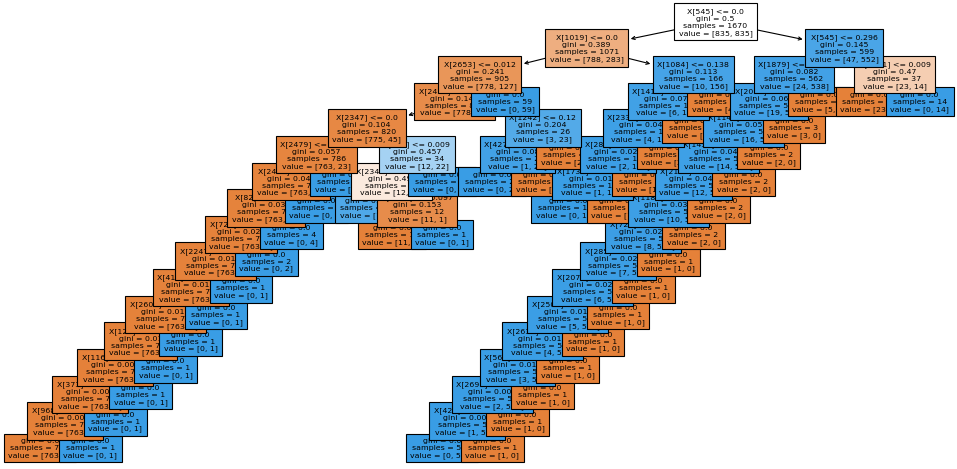

In [78]:
# plotting the tree after post pruning
postpruning = tree.DecisionTreeClassifier(random_state = 42, ccp_alpha = grid_result1)
postpruning.fit(x_train_tfid, y_train_tfid)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15,7.5), dpi = 80)
tree.plot_tree(postpruning, filled = True, fontsize = 7)
fig.savefig('CART Tree Post Pruning.png')
print("The depth of the pruned tree is", postpruning.get_depth())

### Random Forest

4 parameters will be used to tune the model:
* n_estimators
* min_samples_split
* min_samples_leaf
* max_depth -> 14 to 16 was used with reference to the above depth of the pruned decision tree.

In [79]:
m6 = RandomForestClassifier(random_state = 42)
grid = dict() 
grid['n_estimators'] = [150, 200, 250, 300]
grid['min_samples_split'] = [5, 10, 15]
grid['min_samples_leaf'] = [2, 5, 8]
grid['max_depth'] = [14, 15, 16]
grid['bootstrap'] = [True]

# define evaluation process
grid_search6 = RandomizedSearchCV(estimator = m6, param_distributions = grid, n_jobs = -1, cv = 10, scoring = 'accuracy', random_state = 42)
grid_search6.fit(x_train_tfid, y_train_tfid.values.ravel())  
grid_result6 = grid_search6.best_params_

# summarise the best score and configuration
print("Best: %f using %s" % (grid_search6.best_score_, grid_search6.best_params_))

Best: 0.985030 using {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 16, 'bootstrap': True}


In [80]:
# evaluation
m6train = grid_search6.predict(x_train_tfid)
cm6train = confusion_matrix(y_train_tfid, m6train)
m6trainAccuracy = (cm6train[0,0] + cm6train[1,1])/ sum(sum(cm6train))

m6test = grid_search6.predict(x_test_tfid)
cm6test = confusion_matrix(y_test_tfid, m6test)
m6testAccuracy = (cm6test[0,0] + cm6test[1,1])/ sum(sum(cm6test))

print("Random Forest Optimised")
print("===================")
print("Confusion Matrix (Train) \n", cm6train)
print("\nAccuracy (Train)", m6trainAccuracy)

print("===================")
print("Confusion Matrix (Test) \n", cm6test)
print("\nAccuracy (Test)", m6testAccuracy)
print("===================")
print(classification_report(y_test, m6test))

Random Forest Optimised
Confusion Matrix (Train) 
 [[834   1]
 [ 22 813]]

Accuracy (Train) 0.9862275449101796
Confusion Matrix (Test) 
 [[49  0]
 [23 53]]

Accuracy (Test) 0.816
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        49
           1       1.00      0.70      0.82        76

    accuracy                           0.82       125
   macro avg       0.84      0.85      0.82       125
weighted avg       0.87      0.82      0.82       125



### XGBoost

4 parameters will be used to tune the model:
* n_estimators
* learning_rate
* subsample
* max_depth -> 13 to 16 was used with reference to the above depth of the pruned decision tree.

In [81]:
m7 = GradientBoostingClassifier(random_state = 42)
grid = dict() 
grid['n_estimators'] = [200, 300, 400, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [13, 14, 15, 16]

# define evaluation process
grid_search7 = RandomizedSearchCV(estimator = m7, param_distributions = grid, n_jobs = -1, cv = 10, scoring = 'accuracy', random_state = 42)
grid_search7.fit(x_train_tfid, y_train_tfid.values.ravel())
grid_result7 = grid_search7.best_params_

# summarise the best score and configuration
print("Best: %f using %s" % (grid_search7.best_score_, grid_search7.best_params_))

Best: 0.975449 using {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.1}


In [82]:
# evaluation
m7train = grid_search7.predict(x_train_tfid)
cm7train = confusion_matrix(y_train_tfid, m7train)
m7trainAccuracy = (cm7train[0,0] + cm7train[1,1])/ sum(sum(cm7train))

m7test = grid_search7.predict(x_test_tfid)
cm7test = confusion_matrix(y_test_tfid, m7test)
m7testAccuracy = (cm7test[0,0] + cm7test[1,1])/ sum(sum(cm7test))

print("XGBoost Optimised")
print("===================")
print("Confusion Matrix (Train) \n", cm7train)
print("\nAccuracy (Train)", m7trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n", cm7test)
print("\nAccuracy (Test)", m7testAccuracy)
print("===================")
print(classification_report(y_test, m7test))

XGBoost Optimised
Confusion Matrix (Train) 
 [[835   0]
 [  0 835]]

Accuracy (Train) 1.0
Confusion Matrix (Test) 
 [[49  0]
 [14 62]]

Accuracy (Test) 0.888
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        49
           1       1.00      0.82      0.90        76

    accuracy                           0.89       125
   macro avg       0.89      0.91      0.89       125
weighted avg       0.91      0.89      0.89       125



### Multi-Layer Perceptron

In [83]:
m8 = Sequential()
m8.add(Dense(12, input_dim = x_train_tfid.shape[1] , activation = 'relu', name = 'layer1'))
m8.add(Dropout(0.2))
m8.add(Dense(8, activation = 'relu', name = 'layer2'))
m8.add(Dropout(0.2))
m8.add(Dense(1, activation = 'sigmoid', name = 'output'))
m8.summary()

m8.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
m8.fit(x_train_tfid, y_train_tfid.values.ravel(), batch_size = 512, epochs = 50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 12)                32352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
layer2 (Dense)               (None, 8)                 104       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


D:\Users\Anaconda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/layer1/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/layer1/embedding_lookup_sparse/Reshape:0", shape=(None, 12), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/layer1/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


4/4 [==============================] - 0s 8ms/step - loss: 0.6922 - accuracy: 0.5557
Epoch 2/50
4/4 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.6731
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.7054
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.7455
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.7814
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6764 - accuracy: 0.8395
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.8665
Epoch 8/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6640 - accuracy: 0.8976
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.9180
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.9383
Epoch 11/50
4/4 [==============================] -

In [84]:
# evaluation
m8train = m8.predict(x_train_tfid)
m8train = np.where(m8train > 0.5, 1, 0)
cm8train = confusion_matrix(y_train_tfid, m8train)
m8trainAccuracy = (cm8train[0,0] + cm8train[1,1])/sum(sum(cm8train))

m8test = m8.predict(x_test_tfid)
m8test = np.where(m8test > 0.5, 1, 0)
cm8test = confusion_matrix(y_test_tfid, m8test)
m8testAccuracy = (cm8test[0,0] + cm8test[1,1])/sum(sum(cm8test))

print("MLP")
print("===================")
print("Confusion Matrix (Train) \n", cm8train)
print("\nAccuracy (Train)", m8trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n",cm8test)
print("\nAccuracy (Test)", m8testAccuracy)

MLP
Confusion Matrix (Train) 
 [[835   0]
 [  0 835]]

Accuracy (Train) 1.0
Confusion Matrix (Test) 
 [[48  1]
 [10 66]]

Accuracy (Test) 0.912


# Word Embedding - Word2Vec

In [85]:
# https://towardsdatascience.com/an-implementation-guide-to-word2vec-using-numpy-and-google-sheets-13445eebd281

w2v_size = 100 # effectively the size of the hidden layer, recommended 100-300
w2v_window = 15 # number of words left and right of target word; 0<x<5 for syntactic, >5 for semantic
w2v_epoch = 100
w2v_min_count = 5 # min freq for word to be counted

# keras(tokenize and padding for both word2vec and glove) 
sequence_length = 30
batch_size = 64

In [86]:
%%time
documents = [_mail.split() for _mail in x_train]

Wall time: 997 µs


In [87]:
documents

[['rofl', 'true', 'name'],
 ['guy',
  'bitch',
  'act',
  'like',
  "i'd",
  'interest',
  'buy',
  'someth',
  'els',
  'next',
  'week',
  'gave',
  'us',
  'free'],
 ['piti', 'mood', '...', 'suggest'],
 ['ü', 'b', 'go', 'esplanad', 'fr', 'home'],
 ['2nd',
  'time',
  'tri',
  '2',
  'contact',
  'u',
  'u',
  '£',
  '750',
  'pound',
  'prize',
  '2',
  'claim',
  'easi',
  'call',
  '08718727200',
  '8',
  '1',
  '10p',
  'per',
  'minut',
  'bt-national-r'],
 ['remind',
  'o2',
  'get',
  '2.50',
  'pound',
  'free',
  'call',
  'credit',
  'detail',
  'great',
  'offer',
  'pl',
  'repli',
  '2',
  'text',
  'valid',
  'name',
  'hous',
  'postcod'],
 ['huh', 'lei', '...'],
 ['wait', 'til', 'least', 'wednesday', 'see', 'get'],
 ['ard', '6', 'like', 'dat', 'lor'],
 ['ok',
  'lor',
  '...',
  'soni',
  'ericsson',
  'salesman',
  '...',
  'ask',
  'shuhui',
  'say',
  'quit',
  'gd',
  '2',
  'use',
  'consid',
  '...'],
 ['get', 'dump', 'heap', 'mom', 'decid', 'come', 'low', 'bore

In [88]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size = w2v_size, window = w2v_window, min_count = w2v_min_count, workers = 8)
w2v_model.build_vocab(documents)

words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("vocab size: ", vocab_size)

2021-11-04 15:39:12,522 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2021-11-04T15:39:12.521490', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2021-11-04 15:39:12,523 : INFO : collecting all words and their counts
2021-11-04 15:39:12,524 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-04 15:39:12,527 : INFO : collected 2791 word types from a corpus of 9454 raw words and 957 sentences
2021-11-04 15:39:12,528 : INFO : Creating a fresh vocabulary
2021-11-04 15:39:12,531 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 415 unique words (14.869222500895736%% of original 2791, drops 2376)', 'datetime': '2021-11-04T15:39:12.531470', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.

vocab size:  415


In [89]:
w2v_model.wv.vectors.shape

(415, 100)

In [90]:
%%time
w2v_model.train(documents, total_examples = len(documents), epochs = w2v_epoch)

2021-11-04 15:39:13,601 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 415 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=15 shrink_windows=True', 'datetime': '2021-11-04T15:39:13.601778', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
2021-11-04 15:39:13,610 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:13,611 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:13,612 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:13,613 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:13,613 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:13,614 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:13,615 : INFO : worker thread fi

2021-11-04 15:39:13,814 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:13,814 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:13,815 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:13,815 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:13,816 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:13,816 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:13,818 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:13,819 : INFO : EPOCH - 10 : training on 9454 raw words (4439 effective words) took 0.0s, 550178 effective words/s
2021-11-04 15:39:13,828 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:13,828 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:13,829 : INFO : worker thread fi

2021-11-04 15:39:13,952 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:13,955 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:13,955 : INFO : EPOCH - 19 : training on 9454 raw words (4482 effective words) took 0.0s, 514882 effective words/s
2021-11-04 15:39:13,964 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:13,964 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:13,965 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:13,965 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:13,966 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:13,967 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:13,967 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:13,970 : INFO : worker thread fi

2021-11-04 15:39:14,089 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,089 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,090 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,090 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,091 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:14,093 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,094 : INFO : EPOCH - 29 : training on 9454 raw words (4454 effective words) took 0.0s, 526303 effective words/s
2021-11-04 15:39:14,101 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,102 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:14,102 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,103 : INFO : worker thread fi

2021-11-04 15:39:14,225 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,226 : INFO : EPOCH - 38 : training on 9454 raw words (4491 effective words) took 0.0s, 521942 effective words/s
2021-11-04 15:39:14,232 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,233 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:14,233 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,234 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,234 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,235 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,235 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:14,238 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,239 : INFO : EPOCH - 39 : tra

2021-11-04 15:39:14,362 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,362 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,363 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,363 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:14,365 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,365 : INFO : EPOCH - 48 : training on 9454 raw words (4423 effective words) took 0.0s, 562193 effective words/s
2021-11-04 15:39:14,374 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,374 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:14,375 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,376 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,376 : INFO : worker thread fi

2021-11-04 15:39:14,492 : INFO : EPOCH - 57 : training on 9454 raw words (4482 effective words) took 0.0s, 521466 effective words/s
2021-11-04 15:39:14,499 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,500 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:14,500 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,500 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,501 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,501 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,502 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:14,504 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,504 : INFO : EPOCH - 58 : training on 9454 raw words (4499 effective words) took 0.0s, 622268 effective words/s
2021-11-

2021-11-04 15:39:14,625 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,626 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,626 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:14,628 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,628 : INFO : EPOCH - 67 : training on 9454 raw words (4465 effective words) took 0.0s, 578338 effective words/s
2021-11-04 15:39:14,637 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,638 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:14,638 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,639 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,639 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,639 : INFO : worker thread fi

2021-11-04 15:39:14,751 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,751 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:14,752 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,752 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,753 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,753 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,754 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:14,756 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,757 : INFO : EPOCH - 77 : training on 9454 raw words (4453 effective words) took 0.0s, 510624 effective words/s
2021-11-04 15:39:14,765 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,766 : INFO : worker thread fi

2021-11-04 15:39:14,884 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,884 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:14,886 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:14,887 : INFO : EPOCH - 86 : training on 9454 raw words (4464 effective words) took 0.0s, 577670 effective words/s
2021-11-04 15:39:14,897 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:14,898 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:14,898 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:14,898 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:14,899 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:14,899 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:14,899 : INFO : worker thread fi

2021-11-04 15:39:15,019 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:15,019 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-11-04 15:39:15,020 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-11-04 15:39:15,021 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-11-04 15:39:15,021 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-04 15:39:15,022 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-04 15:39:15,024 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-04 15:39:15,024 : INFO : EPOCH - 96 : training on 9454 raw words (4498 effective words) took 0.0s, 517053 effective words/s
2021-11-04 15:39:15,033 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-11-04 15:39:15,033 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-11-04 15:39:15,034 : INFO : worker thread fi

Wall time: 1.48 s


(447898, 945400)

In [91]:
w2v_model.wv.most_similar('prize')

[('guarante', 0.9442059397697449),
 ('2000', 0.9366569519042969),
 ('draw', 0.9053671360015869),
 ('urgent', 0.9049211740493774),
 ('150ppm', 0.904826819896698),
 ('attempt', 0.9032865762710571),
 ('land', 0.8957352042198181),
 ('valid', 0.8936123251914978),
 ('claim', 0.8920899033546448),
 ('£', 0.8757390379905701)]

In [92]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) 

vocab_size = len(tokenizer.word_index) + 1
print("Total words: ", vocab_size)

Total words:  2761
Wall time: 19 ms


In [93]:
%%time
x_train_we = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen = sequence_length)
x_test_we = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen = sequence_length)

Wall time: 26.9 ms


In [95]:
print("x_train", x_train_we.shape)
print("y_train", len(y_train))
print()
print("x_test", x_test_we.shape)
print("y_test", len(y_test))

x_train (957, 30)
y_train 957

x_test (125, 30)
y_test 125


In [96]:
# embedding 
embedding_matrix = np.zeros((vocab_size, w2v_size))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

embedding_layer = Embedding(input_dim = vocab_size,
                            output_dim = w2v_size,
                            weights = [embedding_matrix],
                            input_length = sequence_length,
                            trainable = False)

(2761, 100)


### LSTM

2 parameters will be used to tune the model:
* learning rate
* batch size

In [97]:
# setting class weights for trainsets to deal with imbalanced data
# https://stats.stackexchange.com/questions/342170/how-to-train-an-lstm-when-the-sequence-has-imbalanced-classes
# https://stackoverflow.com/questions/53384231/how-to-apply-smote-technique-oversampling-before-word-embedding-layer

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_train),
                                                  y = y_train)

class_weights_dict = dict(enumerate(class_weights))

In [98]:
def create_model(learning_rate = 0.01):
    m9 = Sequential()
    m9.add(embedding_layer)
    m9.add(Dropout(0.2))
    m9.add(LSTM(100, recurrent_dropout = 0.2))
    m9.add(Dropout(0.2))
    m9.add(Dense(1, activation = 'sigmoid'))
    
    # compile
    opt = Adam(learning_rate = learning_rate)
    m9.compile(loss = 'binary_crossentropy',
               optimizer = opt,
               metrics = ['accuracy'])
    return m9

In [99]:
model = KerasClassifier(build_fn = create_model)

param_grid = dict(batch_size = [64, 128, 256],
                  learning_rate = [0.001, 0.01, 0.1])

grid_w2v = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 1, cv= 10, verbose = 2)

In [100]:
%%time
grid_w2v.fit(x_train_we, y_train, class_weight = class_weights_dict, verbose = 2)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
14/14 - 2s - loss: 0.5103 - accuracy: 0.6980
2/2 [==============================] - 0s 6ms/step - loss: 0.4325 - accuracy: 0.8646
[CV] END .................batch_size=64, learning_rate=0.001; total time=   2.8s
14/14 - 2s - loss: 0.5086 - accuracy: 0.6551
2/2 [==============================] - 0s 15ms/step - loss: 0.3867 - accuracy: 0.9479
[CV] END .................batch_size=64, learning_rate=0.001; total time=   1.9s
14/14 - 2s - loss: 0.4835 - accuracy: 0.6748
2/2 [==============================] - 0s 20ms/step - loss: 0.4158 - accuracy: 0.9062
[CV] END .................batch_size=64, learning_rate=0.001; total time=   1.9s
14/14 - 2s - loss: 0.4729 - accuracy: 0.7375
2/2 [==============================] - 0s 7ms/step - loss: 0.2605 - accuracy: 0.9583
[CV] END .................batch_size=64, learning_rate=0.001; total time=   2.2s
14/14 - 2s - loss: 0.4629 - accuracy: 0.6702


2021-11-04 15:40:24,087 : WARNING : 5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x000002A505FC8EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 14ms/step - loss: 0.2882 - accuracy: 0.9479
[CV] END .................batch_size=64, learning_rate=0.001; total time=   1.9s
14/14 - 2s - loss: 0.4938 - accuracy: 0.5935


2021-11-04 15:40:26,142 : WARNING : 6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x000002A522406C10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 12ms/step - loss: 0.3354 - accuracy: 0.9271
[CV] END .................batch_size=64, learning_rate=0.001; total time=   2.0s
14/14 - 2s - loss: 0.4592 - accuracy: 0.6841
2/2 [==============================] - 0s 14ms/step - loss: 0.2984 - accuracy: 0.9375
[CV] END .................batch_size=64, learning_rate=0.001; total time=   2.2s
14/14 - 2s - loss: 0.4701 - accuracy: 0.7657
2/2 [==============================] - 0s 6ms/step - loss: 0.3539 - accuracy: 0.8947
[CV] END .................batch_size=64, learning_rate=0.001; total time=   2.0s
14/14 - 2s - loss: 0.5101 - accuracy: 0.6206
2/2 [==============================] - 0s 11ms/step - loss: 0.4082 - accuracy: 0.8737
[CV] END .................batch_size=64, learning_rate=0.001; total time=   1.9s
14/14 - 2s - loss: 0.4450 - accuracy: 0.7251
2/2 [==============================] - 0s 15ms/step - loss: 0.3089 - accuracy: 0.9368
[CV] END .................batch_size=64, learning_rate=0.001; total

7/7 - 2s - loss: 0.3435 - accuracy: 0.8548
1/1 [==============================] - 0s 207ms/step - loss: 0.0873 - accuracy: 0.9792
[CV] END .................batch_size=128, learning_rate=0.01; total time=   2.5s
7/7 - 2s - loss: 0.3419 - accuracy: 0.8095
1/1 [==============================] - 0s 196ms/step - loss: 0.2700 - accuracy: 0.9271
[CV] END .................batch_size=128, learning_rate=0.01; total time=   2.2s
7/7 - 2s - loss: 0.2929 - accuracy: 0.7933
1/1 [==============================] - 0s 200ms/step - loss: 0.1783 - accuracy: 0.9583
[CV] END .................batch_size=128, learning_rate=0.01; total time=   2.1s
7/7 - 2s - loss: 0.3208 - accuracy: 0.8271
1/1 [==============================] - 0s 206ms/step - loss: 0.3280 - accuracy: 0.8842
[CV] END .................batch_size=128, learning_rate=0.01; total time=   2.1s
7/7 - 2s - loss: 0.3828 - accuracy: 0.8155
1/1 [==============================] - 0s 203ms/step - loss: 0.4197 - accuracy: 0.8947
[CV] END .................

4/4 - 2s - loss: 1.7209 - accuracy: 0.5633
1/1 [==============================] - 0s 206ms/step - loss: 0.4037 - accuracy: 0.8438
[CV] END ..................batch_size=256, learning_rate=0.1; total time=   2.6s
4/4 - 2s - loss: 1.7876 - accuracy: 0.5703
1/1 [==============================] - 0s 214ms/step - loss: 0.5221 - accuracy: 0.8542
[CV] END ..................batch_size=256, learning_rate=0.1; total time=   2.3s
4/4 - 2s - loss: 1.2498 - accuracy: 0.5958
1/1 [==============================] - 0s 203ms/step - loss: 2.2068 - accuracy: 0.1562
[CV] END ..................batch_size=256, learning_rate=0.1; total time=   2.2s
4/4 - 2s - loss: 1.6433 - accuracy: 0.5540
1/1 [==============================] - 0s 210ms/step - loss: 0.6773 - accuracy: 0.5312
[CV] END ..................batch_size=256, learning_rate=0.1; total time=   2.2s
4/4 - 2s - loss: 1.0978 - accuracy: 0.6508
1/1 [==============================] - 0s 210ms/step - loss: 0.6237 - accuracy: 0.6421
[CV] END .................

GridSearchCV(cv=10,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A4956FB880>,
             n_jobs=1,
             param_grid={'batch_size': [64, 128, 256],
                         'learning_rate': [0.001, 0.01, 0.1]},
             verbose=2)

In [101]:
print("Best: %f using %s" % (grid_w2v.best_score_, grid_w2v.best_params_))

Best: 0.964441 using {'batch_size': 256, 'learning_rate': 0.01}


In [102]:
# evaluation
m9train = grid_w2v.predict(x_train_we)
m9train = np.where(m9train > 0.5, 1, 0)
cm9train = confusion_matrix(y_train, m9train)
m9trainAccuracy = (cm9train[0,0] + cm9train[1,1])/sum(sum(cm9train))

m9test = grid_w2v.predict(x_test_we)
m9test = np.where(m9test > 0.5, 1, 0)
cm9test = confusion_matrix(y_test, m9test)
m9testAccuracy = (cm9test[0,0] + cm9test[1,1])/sum(sum(cm9test))

print("LSTM")
print("===================")
print("Confusion Matrix (Train) \n", cm9train)
print("\nAccuracy (Train)", m9trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n",cm9test)
print("\nAccuracy (Test)", m9testAccuracy)

LSTM
Confusion Matrix (Train) 
 [[823  12]
 [ 10 112]]

Accuracy (Train) 0.9770114942528736
Confusion Matrix (Test) 
 [[48  1]
 [ 7 69]]

Accuracy (Test) 0.936


# Word Embedding - GloVe

In [103]:
# download the model here:
# https://github.com/stanfordnlp/GloVe

glove_dir = './gloVe/glove.6B.50d.txt'

In [104]:
embeddings_index = {}

# load the entire GloVe word embedding file into memory as a dictionary of word to embedding array
f = open(glove_dir, encoding = "utf8")
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400001 word vectors.


In [105]:
embed_vector_len = embeddings_index['the'].shape[0]

In [106]:
# create a matrix of one embedding for each word in the training dataset
embedding_matrix = np.zeros((vocab_size, embed_vector_len))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [107]:
embedding_layer = Embedding(vocab_size, embed_vector_len, weights = [embedding_matrix], input_length = sequence_length, trainable = False)

### LSTM

In [108]:
def create_model(learning_rate = 0.01):
    m10 = Sequential()
    m10.add(embedding_layer)
    m10.add(Dropout(0.2))
    m10.add(LSTM(100, recurrent_dropout = 0.2))
    m10.add(Dropout(0.2))
    m10.add(Dense(1, activation = 'sigmoid'))
    
    # compile
    opt = Adam(learning_rate = learning_rate)
    m10.compile(loss = 'binary_crossentropy',
               optimizer = opt,
               metrics = ['accuracy'])
    return m10

In [109]:
model = KerasClassifier(build_fn=create_model)

# if early stopping is used in the grid search then there's no point to tuning number of epochs
# because experimentation has shown that overfitting happens at <50 epochs
param_grid = dict(batch_size=[64, 128, 256],
                  learning_rate=[0.001, 0.01, 0.1])

grid_glove = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 1, cv = 10, verbose = 0)

In [110]:
%%time
grid_glove.fit(x_train_we, y_train, class_weight = class_weights_dict, verbose = 0)

1/1 [==============================] - 0s 203ms/step - loss: 0.5669 - accuracy: 0.7263
Wall time: 3min 46s


GridSearchCV(cv=10,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000002A522439FD0>,
             n_jobs=1,
             param_grid={'batch_size': [64, 128, 256],
                         'learning_rate': [0.001, 0.01, 0.1]})

In [111]:
print("Best: %f using %s" % (grid_glove.best_score_, grid_glove.best_params_))

Best: 0.956053 using {'batch_size': 64, 'learning_rate': 0.01}


In [112]:
# evaluation
m10train = grid_glove.predict(x_train_we)
m10train = np.where(m10train > 0.5, 1, 0)
cm10train = confusion_matrix(y_train, m10train)
m10trainAccuracy = (cm10train[0,0] + cm10train[1,1])/sum(sum(cm10train))

m10test = grid_glove.predict(x_test_we)
m10test = np.where(m10test > 0.5, 1, 0)
cm10test = confusion_matrix(y_test, m10test)
m10testAccuracy = (cm10test[0,0] + cm10test[1,1])/sum(sum(cm10test))

print("LSTM")
print("===================")
print("Confusion Matrix (Train) \n", cm10train)
print("\nAccuracy (Train)", m10trainAccuracy)
print("===================")
print("Confusion Matrix (Test) \n",cm10test)
print("\nAccuracy (Test)", m10testAccuracy)

LSTM
Confusion Matrix (Train) 
 [[808  27]
 [  8 114]]

Accuracy (Train) 0.9634273772204807
Confusion Matrix (Test) 
 [[49  0]
 [12 64]]

Accuracy (Test) 0.904


# BERT

In [23]:
# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [24]:
df_train = pd.read_csv('./datasets/SMS_train.csv', encoding = 'unicode_escape')
df_test = pd.read_csv('./datasets/SMS_test.csv', encoding = 'unicode_escape')

In [25]:
df_train = data_preprocessing(df_train)
df_test = data_preprocessing(df_test)

In [26]:
X_train = list(df_train['Message_body'])
X_test = list(df_test['Message_body'])

In [27]:
y_train = list(df_train['Label'])
y_test = list(df_test['Label'])

In [28]:
X_train_tokenized = tokenizer(X_train, padding = True, truncation = True, max_length = 512)
X_test_tokenized = tokenizer(X_test, padding = True, truncation = True, max_length = 512)

In [29]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels = None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item


    def __len__(self):
        return len(self.encodings["input_ids"])

In [30]:
train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)

In [31]:
# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true = labels, y_pred = pred)
    recall = recall_score(y_true = labels, y_pred = pred)
    precision = precision_score(y_true = labels, y_pred = pred)
    f1 = f1_score(y_true=labels, y_pred = pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [32]:
# Define Trainer
args = TrainingArguments(
    output_dir = "output",
    evaluation_strategy = "steps",
    eval_steps = 500,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    num_train_epochs = 1,
    seed = 42,
    load_best_model_at_end = True,
)

In [33]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)],
)

In [34]:
test_trainer = Trainer(model, args = args)

In [35]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 957
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 240


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=240, training_loss=0.09706520239512126, metrics={'train_runtime': 74.2309, 'train_samples_per_second': 12.892, 'train_steps_per_second': 3.233, 'total_flos': 68850818744400.0, 'train_loss': 0.09706520239512126, 'epoch': 1.0})

In [36]:
raw_pred_train, _, _ = test_trainer.predict(train_dataset)

***** Running Prediction *****
  Num examples = 957
  Batch size = 4


In [37]:
raw_pred, _, _ = test_trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 125
  Batch size = 4


In [38]:
# Preprocess raw predictions for train set
y_pred_train = np.argmax(raw_pred_train, axis = 1)
# Preprocess raw predictions for test set
y_pred = np.argmax(raw_pred, axis = 1)

In [39]:
# Confusion Matrix for trainset
confusion_matrix(y_pred_train, y_train)

array([[835,   4],
       [  0, 118]], dtype=int64)

In [40]:
# Confusion Matrix for testset
confusion_matrix(y_pred, y_test)

array([[49,  3],
       [ 0, 73]], dtype=int64)

In [41]:
# Report for Test set only
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.96      1.00      0.98        73

    accuracy                           0.98       125
   macro avg       0.98      0.97      0.98       125
weighted avg       0.98      0.98      0.98       125



In [42]:

m11trainAccuracy = (confusion_matrix(y_pred_train, y_train)[0][0] + confusion_matrix(y_pred_train, y_train)[1][1]) / sum(sum(confusion_matrix(y_pred_train, y_train)))

m11testAccuracy = (confusion_matrix(y_pred, y_test)[0][0] + confusion_matrix(y_pred, y_test)[1][1]) / sum(sum(confusion_matrix(y_pred, y_test)))


In [43]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Evaluation of Models

In [113]:
# creating a dataframe 
summary = [
    ['CV - LogReg', m1trainAccuracy, m1testAccuracy], 
    ['CV - RF ', m2trainAccuracy, m2testAccuracy], 
    ['CV - XGB', m3trainAccuracy, m3testAccuracy],
    ['CV - MLP', m4trainAccuracy, m4testAccuracy],
    ['Tfidf - LogReg', m5trainAccuracy, m5testAccuracy],
    ['Tfidf - RF', m6trainAccuracy, m6testAccuracy],
    ['Tfidf - XGB', m7trainAccuracy, m7testAccuracy],
    ['Tfidf - MLP', m8trainAccuracy, m8testAccuracy],
    ['W2V - LSTM', m9trainAccuracy, m9testAccuracy],
    ['GloVe - LSTM', m10trainAccuracy, m10testAccuracy],
    ['BERT', m11trainAccuracy, m11testAccuracy]
]

summaryTable = pd.DataFrame(summary, columns = ['Model', 'Train Accuracy', 'Test Accuracy'])
pd.options.display.float_format = '{:.2%}'.format

summaryTable

,Model,Train Accuracy,Test Accuracy
0,CV - LogReg,98.20%,84.80%
1,CV - RF,92.46%,88.00%
2,CV - XGB,95.15%,87.20%
3,CV - MLP,99.16%,86.40%
4,Tfidf - LogReg,99.40%,90.40%
5,Tfidf - RF,98.62%,81.60%
6,Tfidf - XGB,100.00%,88.80%
7,Tfidf - MLP,100.00%,91.20%
8,W2V - LSTM,97.70%,93.60%
9,GloVe - LSTM,96.34%,90.40%


In [114]:
summaryTableSorted = summaryTable.sort_values(by = ['Test Accuracy'], ascending = False).reset_index().drop('index', axis=1)
summaryTableSorted

,Model,Train Accuracy,Test Accuracy
0,BERT,99.58%,97.60%
1,W2V - LSTM,97.70%,93.60%
2,Tfidf - MLP,100.00%,91.20%
3,Tfidf - LogReg,99.40%,90.40%
4,GloVe - LSTM,96.34%,90.40%
5,Tfidf - XGB,100.00%,88.80%
6,CV - RF,92.46%,88.00%
7,CV - XGB,95.15%,87.20%
8,CV - MLP,99.16%,86.40%
9,CV - LogReg,98.20%,84.80%
